# Tensorflow 2.0 GPU vs CPU Performance

In [1]:
# conda activate tensorflow_v2_gpu

# tensorboard            2.0.2
# tensorboard-plugin-wit 1.8.0
# tensorflow             2.4.1
# tensorflow-estimator   2.0.1
# tensorflow-gpu         2.0.0

In [2]:
import tensorflow as tf

print(tf.__version__)

tf.config.experimental.list_physical_devices(device_type=None)

2.6.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [4]:
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
# from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import load_model
from keras import backend as K
import time

In [5]:
#data preprocessing
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28,28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_test=x_test.astype('float32')
x_train=x_train.astype('float32')
mean=np.mean(x_train)
std=np.std(x_train)
x_test = (x_test-mean)/std
x_train = (x_train-mean)/std

print("counts of x_train : {}, y_train : {}, x_test : {}, y_test : {}".format(
    len(x_train), len(y_train), len(x_test), len(y_test)))

counts of x_train : 60000, y_train : 60000, x_test : 10000, y_test : 10000


In [6]:
#labels
num_classes=10
y_train = k.utils.np_utils.to_categorical(y_train, num_classes)
y_test = k.utils.np_utils.to_categorical(y_test, num_classes)
print("counts of x_train : {}, y_train : {}, x_test : {}, y_test : {}".format(
    len(x_train), len(y_train), len(x_test), len(y_test)))

counts of x_train : 60000, y_train : 60000, x_test : 10000, y_test : 10000


### Tensorflow with CPU only

In [7]:
from tensorflow.keras.optimizers import Adam

In [16]:
num_filter=32
num_dense=512
drop_dense=0.7
ac='relu'
learningrate=0.001

with tf.device("/cpu:0"):
    model = Sequential()

    model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

    model.add(Flatten())                        
    model.add(Dense(num_dense, activation=ac))
    model.add(BatchNormalization())
    model.add(Dropout(drop_dense))
    model.add(Dense(10, activation='softmax'))

    adm=Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)


C:\Users\G S SRENATH KUMAR\anaconda3\envs\Tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
cpu_list=[]
batch_sizes = []
with tf.device("/cpu:0"):
    for i in range(0,7):
        k=8*2**i
        print("batch size "+str(k))
        t1 = time.time()
        model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))
        t2 = time.time()
        cpu_list.append(int(t2-t1))
        batch_sizes.append(k)

batch size 8
 309/7500 [>.............................] - ETA: 1:38 - loss: 0.7019 - accuracy: 0.7832

KeyboardInterrupt: 

In [22]:
print("cpu_list : ", cpu_list)

cpu_list :  [110, 88, 77, 59, 51, 49, 48]


### Tensorflow with GPU only

In [8]:
#build model

num_filter=32
num_dense=512
drop_dense=0.7
ac='relu'
learningrate=0.001

model = Sequential()

model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

model.add(Flatten())                        
model.add(Dense(num_dense, activation=ac))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(10, activation='softmax'))

adm=Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)

C:\Users\G S SRENATH KUMAR\anaconda3\envs\Tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Now we train the model with gpu or cpu for different batch sizes. The larger the batch size, the more the parallelisation of matrix multiplications in the gpu speeds up the training compared to the cpu. The gpu load goes up to 95 percent for batch size 512, with 1.6GB used. Much larger batches require better graphics cards.

In [9]:
# # with GPU (the default in my setup)
# for i in range(1,2):
#     k=8*2**i
#     print("batch size "+str(k))
#     model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))

In [11]:
gpu_list=[]
batch_sizes = []
print("gpu_list : ", gpu_list)
with tf.device("/gpu:0"):
    for i in range(0,7):
        k=8*2**i
        print("batch size "+str(k))
        t1 = time.time()
        model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))
        t2 = time.time()
        gpu_list.append(int(t2-t1))
        batch_sizes.append(k)

gpu_list :  []
batch size 8
7500/7500 [==============================] - 46s 5ms/step - loss: 0.2305 - accuracy: 0.9315 - val_loss: 0.0523 - val_accuracy: 0.9831
batch size 16
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0755 - accuracy: 0.9782 - val_loss: 0.0424 - val_accuracy: 0.9869
batch size 32
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0445 - accuracy: 0.9871 - val_loss: 0.0206 - val_accuracy: 0.9942
batch size 64
938/938 [==============================] - 6s 6ms/step - loss: 0.0243 - accuracy: 0.9924 - val_loss: 0.0159 - val_accuracy: 0.9948
batch size 128
469/469 [==============================] - 4s 8ms/step - loss: 0.0159 - accuracy: 0.9951 - val_loss: 0.0146 - val_accuracy: 0.9950
batch size 256
235/235 [==============================] - 3s 11ms/step - loss: 0.0122 - accuracy: 0.9966 - val_loss: 0.0129 - val_accuracy: 0.9963
batch size 512
118/118 [==============================] - 2s 17ms/step - loss: 0.0089 - accuracy: 0.9972

In [10]:
gpu_list=[]
batch_sizes = []
print("gpu_list : ", gpu_list)

for i in range(0,7):
    k=8*2**i
    print("batch size "+str(k))
    t1 = time.time()
    model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))
    t2 = time.time()
    gpu_list.append(int(t2-t1))
    batch_sizes.append(k)

gpu_list :  []
batch size 8
 822/7500 [==>...........................] - ETA: 33s - loss: 0.4981 - accuracy: 0.8508

KeyboardInterrupt: 

In [15]:
print("gpu_list : ", gpu_list)

gpu_list :  [40, 23, 11, 5, 3, 2, 2]


### Test 1 :-  GPU VS CPU 

NameError: name 'cpu_list' is not defined

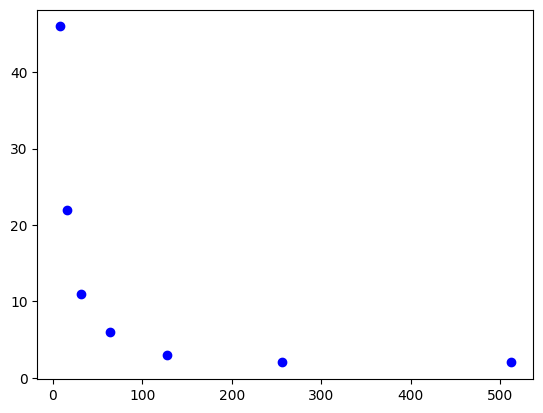

In [13]:
# plot the comparison. The training with gpu is faster by a factor of about 4-6
plt.plot(batch_sizes,gpu_list,'bo')
plt.plot(batch_sizes,cpu_list,'ro')
plt.plot(batch_sizes,gpu_list,'b--')
plt.plot(batch_sizes,cpu_list,'r--')
plt.ylabel('training time per epoch (s)')
plt.xlabel('batch size')
plt.legend(['gpu', 'cpu'], loc='upper right')
plt.ylim([0,400])
#plt.savefig('CPUvsGPU.png') 
plt.show()

### Test 2 :-  GPU VS CPU 

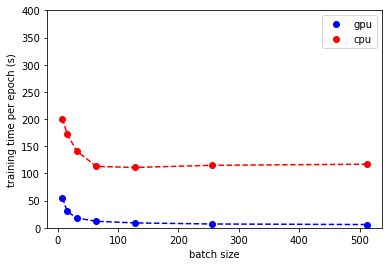

In [23]:
# plot the comparison. The training with gpu is faster by a factor of about 4-6
plt.plot(batch_sizes,gpu_list,'bo')
plt.plot(batch_sizes,cpu_list,'ro')
plt.plot(batch_sizes,gpu_list,'b--')
plt.plot(batch_sizes,cpu_list,'r--')
plt.ylabel('training time per epoch (s)')
plt.xlabel('batch size')
plt.legend(['gpu', 'cpu'], loc='upper right')
plt.ylim([0,400])
#plt.savefig('CPUvsGPU.png') 
plt.show()

In [24]:
ratio_list=[j/k for (j, k) in zip(cpu_list,gpu_list)]
ratio_list

[3.6545454545454548,
 5.733333333333333,
 7.833333333333333,
 9.416666666666666,
 12.333333333333334,
 16.428571428571427,
 19.5]